In [1]:
# Import dependencies
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import json
import pandas as pd
from pandas.io import sql
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score   
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import r2_score
from consts import *
from sklearn.svm import SVC
#from gcloud import storage
%matplotlib inline

In [2]:
# Connecting to Postgres instance
engine = create_engine(CREATE_ENGINE_STR)

In [3]:
# Printing info for table names 
print (engine.table_names())

['res_lr', 'committees', 'candidates', 'education', 'res_votes_rf', 'res_votes_dt_az', 'res_votes_dt_mi', 'res_votes_dt_fl', 'res_log', 'six_state_donations', 'res_votes_dt_nc', 'res_votes_dt_pa', 'res_votes_dt_wi', 'health_results', 'res_rf', 'donations', 'classifying_results', 'health_metrics', 'agg_county_votes', 'res_counties', 'birth_death_rate', 'postal_codes', 'res_stats_donations', 'agg_county_donors', 'res_stats_voters', 'pres_votes_6t', 'unemployment', 'res_votes_rf_wi', 'res_votes_rf_az', 'res_votes_rf_pa', 'res_votes_lr_az', 'res_votes_lr_mi', 'res_votes_lr_fl', 'res_votes_lr_nc', 'res_votes_lr_pa', 'res_votes_lr_wi', 'pred_votes', 'res_votes_rf_mi', 'res_votes_rf_fl', 'res_votes_rf_nc']


In [4]:
#Define the Linear Regression Structured Machine Learning
def state_sml(state_tuple, state, election_yr, unemployment_df, education_df, birth_death_df):
    counties_tuples = state_tuple[0]    
    donor_tuples = state_tuple[1]
    
    #Loop through each election year county dict
    for i in range(0, len(counties_tuples)):
        #Select the corresponding counties/votes and donor info for that election yr
        counties_votes_dict = counties_tuples[i]
        donor_tuple = donor_tuples[i]
        
        county_dict = {}
        #Loop through all the votes organized by county
        for c in counties_votes_dict:
            #Kepp unique dict of counties
            if c not in county_dict:
                county_dict[c] = {}
            #Get the number of votes by county
            county_votes = counties_votes_dict[c]
            #Update the vote dict
            votes_dict = set_votes_dict(county_dict[c], county_votes, donor_tuple)
            #Update the county dict with the updated votes dict
            county_dict[c] = votes_dict

In [5]:
#Machine Learning models run on the donation data
def donation_votes_linear_regression(df, y_param, state):
    print("donation_votes_linear_regression")
    #Set all the votes cols of interest
    votes_cols = ["PopPct_Urban", "Unemployment", "PopDen_Urban", "PopPct_Rural", "PopDen_Rural"]
    #Set all the donors cols of interest
    donors_cols = ["county", "election_year", "blue_amt", "red_amt", "total_amt", "blue_num", "red_num"]
    
    #Set the Machine Learning X cols
    x_cols = votes_cols + donors_cols
    
    #Run machine learning models on the donation of the state
    return run_lr_xy(df, y_param, x_cols, state, "lr_votes")

In [6]:
def run_lr_xy(df, y_param, x_cols, state, dir_name):
    #Create the Y values
    y_df = select_columns(df, [y_param])
    y = y_df[y_param].values

    #Set X Cols to the everything but the parameter to run the ML model
    X_df = select_columns(df, x_cols)
    X = X_df[x_cols].values
    
    print(f"y len {len(y)} x len {len(X)}")
    #Run Linear Regression Model on X,y
    print(f"Running a Linear Regression Model with y={y_param} and x_cols={x_cols} state={state}")
    #return run_linear_regression(X, y, y_param, state, dir_name)
    #return run_rf_regression(X, y, y_param, state, dir_name)
    return run_dt_regression(X, y, y_param, state, dir_name)

In [7]:
def save_db(state, y_param, r2_score_val, file_name, table_name):
    df = pd.DataFrame()
    df['state'] = [state]
    df['sml_param'] = [y_param]
    df['r2_score'] = [r2_score_val]
    df['file_name'] = [file_name]
    df.to_sql(table_name, con=engine, if_exists="append")

In [8]:
def run_linear_regression(X, y, y_param, state, dir_name):    
    # Split the preprocessed data into a training and testing dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78, test_size=SML_TEST_SIZE)
    
    #Donations can't be negatives so take absolute value.
    X_train = [abs(number) for number in X_train]
    y_train = [abs(number) for number in y_train]
    X_test = [abs(number) for number in X_test]
    y_test = [abs(number) for number in y_test]
    #Scale the values
    #X_train_scaled = StandardScaler().fit_transform(X_train)
    #X_test_scaled = StandardScaler().fit_transform(X_test)
    
    model_type = "LinearRegression"
    #Test out different models
    model = LinearRegression()
    
    #Train the model 
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    y_train_pred = [abs(number) for number in y_train_pred]
    y_test_pred = [abs(number) for number in y_test_pred]
    
    #Get the score of this model
    r2_score_val = r2_score(y_test, y_test_pred)
    score_str = f"r2_score:{r2_score_val}"
    #Plot the data
    title = create_title(model_type, y_param, score_str)
    file_name = create_file_name("lr", y_param, state)
    plot_data(y_test, y_train, y_test_pred, y_train_pred, title, file_name, dir_name)
    
    save_db(state, y_param, r2_score_val, file_name, TABLE_RES_LR)
    
    return model

In [9]:
def run_rf_regression(X, y, y_param, state, dir_name):    
    # Split the preprocessed data into a training and testing dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78, test_size=SML_TEST_SIZE)
    
    #Donations can't be negatives so take absolute value.
    X_train = [abs(number) for number in X_train]
    y_train = [abs(number) for number in y_train]
    X_test = [abs(number) for number in X_test]
    y_test = [abs(number) for number in y_test]
    
    #X_train_scaled = StandardScaler().fit_transform(X_train)
    #X_test_scaled = StandardScaler().fit_transform(X_test)
    
    model_type = "RandomForest"
    #Test out different models
    model = RandomForestClassifier(n_estimators=100)
    
    #Train the model 
    model.fit(X_train, y_train)
    
    #Predict the values based on the X test values
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    #y_train_pred = [abs(number) for number in y_train_pred]
    #y_test_pred = [abs(number) for number in y_test_pred]
    
    #Get the score of this model
    r2_score_val = r2_score(y_test, y_test_pred)
    score_str = f"r2_score:{r2_score_val}"
    #Plot the data
    title = create_title(model_type, y_param, score_str)
    file_name = create_file_name("rf", y_param, state)
    plot_data(y_test, y_train, y_test_pred, y_train_pred, title, file_name, dir_name)
    
    save_db(state, y_param, r2_score_val, file_name, TABLE_RES_VOTES_RF)
    
    return model

In [10]:
def run_dt_regression(X, y, y_param, state, dir_name):    
    # Split the preprocessed data into a training and testing dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78, test_size=SML_TEST_SIZE)
    
    #Donations can't be negatives so take absolute value.
    X_train = [abs(number) for number in X_train]
    y_train = [abs(number) for number in y_train]
    X_test = [abs(number) for number in X_test]
    y_test = [abs(number) for number in y_test]
    
    #X_train_scaled = StandardScaler().fit_transform(X_train)
    #X_test_scaled = StandardScaler().fit_transform(X_test)
    
    model_type = "DecisionTree"
    #Test out different models
    model = DecisionTreeClassifier(random_state=0)
    
    #Train the model 
    model.fit(X_train, y_train)
    
    #Predict the values based on the X test values
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    y_train_pred = [abs(number) for number in y_train_pred]
    y_test_pred = [abs(number) for number in y_test_pred]
    
    #Get the score of this model
    r2_score_val = r2_score(y_test, y_test_pred)
    score_str = f"r2_score:{r2_score_val}"
    #Plot the data
    title = create_title(model_type, y_param, score_str)
    file_name = create_file_name("dt", y_param, state)
    plot_data(y_test, y_train, y_test_pred, y_train_pred, title, file_name, dir_name)
    
    save_db(state, y_param, r2_score_val, file_name, TABLE_RES_VOTES_DT)
    
    return model

In [11]:
# Holding area for function to plot data
def plot_data(y_test, y_trained, y_pred_test, y_pred_train, title, file_name, dir_name):
    plt.scatter(y_test, y_pred_test, c="blue", label="Testing Data")
    plt.scatter(y_trained, y_pred_train, c="orange", label="Training Data")
    plt.legend()
    plt.hlines(y=0, xmin=min(y_test), xmax=max(y_test))
    plt.title(title)
    plt.show()
    
    file_dir = f"results/{dir_name}/{file_name}"
    plt.savefig(file_dir)
    
    #Clear the plot
    plt.clf()
    
    #Save the plot data to gcloud
    #save_image_to_gcloud_lr(plt, file_name)

In [12]:
#Get all donation records for a single state and return it in a dataframe
def query_all(table_name, state):
    #Run queries to get all donation records from the states into dfs
    select_sql = f'select * from {table_name} where election_year != 2020 and state=\'{state}\';'
    df = pd.read_sql_query(select_sql,con=engine)
    return df

In [13]:
#Get all donation records for a single state and return it in a dataframe
def query_total_votes(state):
    table_name = "agg_county_votes"
    #Run queries to get all donation records from the states into dfs
    select_sql = f'select * from {table_name} where election_year = 2016 and state=\'{state}\';'
    df = pd.read_sql_query(select_sql,con=engine)
    return df

In [14]:
#Get all donation records for a single state and return it in a dataframe
def query_this_election(table_name, state):
    #Run queries to get all donation records from the states into dfs
    select_sql = f'select * from {table_name} where election_year = 2020 and state=\'{state}\';'
    df = pd.read_sql_query(select_sql,con=engine)
    return df

In [15]:
#Get all donation records for a single state and return it in a dataframe
def donor_state_query(state):
    param_str = '"TRANSACTION_AMT", "CITY", "STATE", "ZIP", "EMPLOYER", "OCCUPATION", "CMTE_ID"'
    
    #Run queries to get all donation records from the states into dfs
    select_sql = f'select {param_str} from {TABLE_SIX_STATE_DONATIONS} where "STATE"=\'{state.upper()}\''
    df = pd.read_sql_query(select_sql, con=engine)
    return df

In [16]:
def agg_ml(state):
    print(f"agg_ml {state}")
    
    zips_df = pd.read_sql_query(f'select * from postal_codes where state=\'{state}\'',con=engine)
    unique_counties = zips_df["county"].unique()
    
    for i in range(len(unique_counties)):
        word = unique_counties[i].split(' County', 1)
        unique_counties[i] = word[0].capitalize()
    
    #2016 total votes
    df_total_votes = query_total_votes(state)
    df_total_votes = df_total_votes.dropna(subset=['blue_votes', 'red_votes', 'other_votes'])
    
    #Get donors for this election year
    agg_donors_this_df = query_this_election(TABLE_AGG_DONORS, state)
    
    #Get all donations from 2000-2016
    agg_donors_df = query_all(TABLE_AGG_DONORS, state)
    #Filter by actual unique counties from the state
    agg_donors_df = agg_donors_df[agg_donors_df["county"].isin(unique_counties)]
    agg_donors_df = agg_donors_df.dropna(subset=['county', 'blue_num', 'red_num', 'other_num'])
    
    #agg_donors_df = agg_donors_df.fillna(0)
    agg_donors_df = label_enc(agg_donors_df)
    
    agg_votes_df = query_all(TABLE_AGG_VOTES, state)
    #agg_votes_df = agg_votes_df.fillna(0)
    agg_votes_df = agg_votes_df.dropna(subset=['blue_votes', 'red_votes', 'other_votes'])
    agg_votes_df = label_enc(agg_votes_df)
    
    #Merge on the three fields that make it unique: county, state, and election_year
    merged_df = agg_donors_df.merge(agg_votes_df, left_on=['county', 'state', 'election_year'], right_on=['county', 'state', 'election_year'], suffixes=("_donors", "_votes"))
    merged_df = merged_df.fillna(0)
    
    #Run a linear regression analysis on the merged dataset, returns a trained model
    model_blue = donation_votes_linear_regression(merged_df, "blue_votes", state)
    model_red = donation_votes_linear_regression(merged_df, "red_votes", state)
    model_other = donation_votes_linear_regression(merged_df, "other_votes", state)
    
    #Filter by actual unique counties from the state
    agg_donors_this_df = agg_donors_this_df[agg_donors_this_df["county"].isin(unique_counties)]
    agg_donors_this_df = agg_donors_this_df.dropna(subset=['blue_num', 'red_num', 'other_num'])
    #agg_donors_this_df = agg_donors_this_df.fillna(0)
    this_election_df = df_total_votes.merge(agg_donors_this_df, left_on=['county', 'state'], right_on=['county', 'state'], suffixes=("_donors", "_votes"), how='left')
    this_election_df = this_election_df.fillna(0)
    this_election_df_orig = this_election_df.copy()
    this_election_df = label_enc(this_election_df)
    
    #Set all the donors cols of interest
    votes_cols = ["PopPct_Urban", "Unemployment", "PopDen_Urban", "PopPct_Rural", "PopDen_Rural"]
    donors_cols = ["county", "election_year_donors", "blue_amt", "red_amt", "total_amt", "blue_num", "red_num"]
    x_cols = votes_cols + donors_cols
    agg_donors_this_df_test = select_columns(this_election_df, x_cols)   
    
    # Split the preprocessed data into a training and testing dataset    
    #X_test_scaled = MinMaxScaler().fit_transform(agg_donors_this_df_test)
    X_test_scaled = agg_donors_this_df_test
    y_test_blue_pred = model_blue.predict(X_test_scaled)
    y_test_red_pred = model_red.predict(X_test_scaled)
    y_test_other_pred = model_other.predict(X_test_scaled)
    
    print(f"len of y_test_blue {len(y_test_blue_pred)} y_test_red{len(y_test_red_pred)} y_test_other_pred{len(y_test_other_pred)}")
    
    this_election_df_orig["total_votes_2016"] = this_election_df_orig["total_votes"]
    this_election_df_orig["predict_blue_votes"] = y_test_blue_pred
    this_election_df_orig["predict_red_votes"] = y_test_red_pred
    this_election_df_orig["predict_other_votes"] = y_test_other_pred
    this_election_df_orig["predict_total_votes"] = this_election_df_orig["predict_blue_votes"] + this_election_df_orig["predict_red_votes"] + this_election_df_orig["predict_other_votes"]
    
    this_election_df_orig["predict_blue_votes_percent"] = (this_election_df_orig["predict_blue_votes"] / this_election_df_orig["predict_total_votes"]) 
    this_election_df_orig["predict_red_votes_percent"] = (this_election_df_orig["predict_red_votes"] / this_election_df_orig["predict_total_votes"]) 
    this_election_df_orig["predict_other_votes_percent"] = (this_election_df_orig["predict_other_votes"] / this_election_df_orig["predict_total_votes"]) 
    
    #State, County, blue, red votes
    #table_name = f"res_votes_lr_{state.lower()}"
    #table_name = f"res_votes_rf_{state.lower()}"
    table_name = f"res_votes_dt_{state.lower()}"
    
    results_df = select_columns(this_election_df_orig, ["predict_blue_votes", "predict_red_votes", "predict_other_votes", "predict_blue_votes_percent", "predict_red_votes_percent", "predict_other_votes_percent", "total_votes_2016", "state", "county"])   
    results_df.to_sql(table_name, con=engine, if_exists="replace")
    
    print(f"Prediction for Votes! States = {state}")

In [17]:
def state_ml(committee_df, state):
    #Loop through each state and run separate LR models on each state.
    print(f"state_ml {state}")
    #Using the aggregate amounts for each state, predict the winning party
    donor_df = donor_state_query(state)
    donor_df["TRANSACTION_AMT"] =donor_df["TRANSACTION_AMT"].abs()
    
    #Add party column to donor data frame
    donor_df = committee_df.merge(donor_df, left_on='CMTE_ID', right_on='CMTE_ID')
    donor_df = donor_df.dropna(subset=['CMTE_PTY_AFFILIATION'])
    
    #Print unique ids
    unique_aff = donor_df["CMTE_PTY_AFFILIATION"].unique()
    print(unique_aff)

    donor_df = merge_cmtid_party(donor_df)
    
    #donor_df = donor_df.fillna(0)
    print("Running label encode")
    donor_df = label_enc(donor_df)
    
    #Run the machine learning models on the donation set
    print(f"Linear Regression on state: {state}")
    
    y_param = "TRANSACTION_AMT"
    X_cols = ["CITY", "STATE", "ZIP", "EMPLOYER", "OCCUPATION"]
    
    #Run some machine learning models on the donation of the state
    state_model = run_lr_xy(donor_df, y_param, X_cols, state, "lr_trans_amt")

Main
agg_ml AZ
county
state
county
state
winning_party
donation_votes_linear_regression
y len 75 x len 75
Running a Linear Regression Model with y=blue_votes and x_cols=['PopPct_Urban', 'Unemployment', 'PopDen_Urban', 'PopPct_Rural', 'PopDen_Rural', 'county', 'election_year', 'blue_amt', 'red_amt', 'total_amt', 'blue_num', 'red_num'] state=AZ


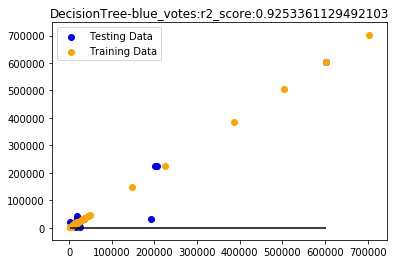

donation_votes_linear_regression
y len 75 x len 75
Running a Linear Regression Model with y=red_votes and x_cols=['PopPct_Urban', 'Unemployment', 'PopDen_Urban', 'PopPct_Rural', 'PopDen_Rural', 'county', 'election_year', 'blue_amt', 'red_amt', 'total_amt', 'blue_num', 'red_num'] state=AZ


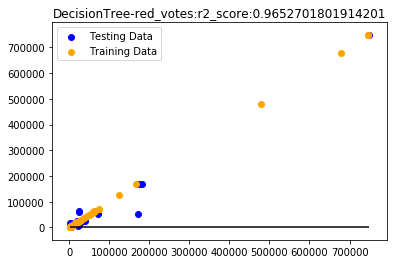

donation_votes_linear_regression
y len 75 x len 75
Running a Linear Regression Model with y=other_votes and x_cols=['PopPct_Urban', 'Unemployment', 'PopDen_Urban', 'PopPct_Rural', 'PopDen_Rural', 'county', 'election_year', 'blue_amt', 'red_amt', 'total_amt', 'blue_num', 'red_num'] state=AZ


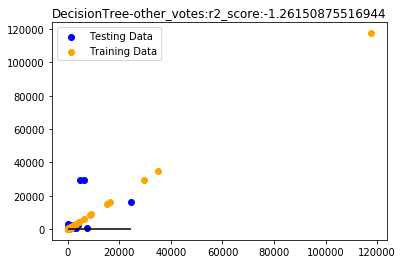

county
state
winning_party
len of y_test_blue 15 y_test_red15 y_test_other_pred15
Prediction for Votes! States = AZ
agg_ml MI
county
state
county
state
winning_party
donation_votes_linear_regression
y len 384 x len 384
Running a Linear Regression Model with y=blue_votes and x_cols=['PopPct_Urban', 'Unemployment', 'PopDen_Urban', 'PopPct_Rural', 'PopDen_Rural', 'county', 'election_year', 'blue_amt', 'red_amt', 'total_amt', 'blue_num', 'red_num'] state=MI


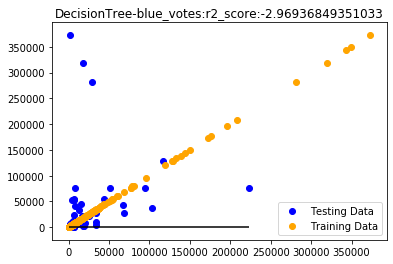

donation_votes_linear_regression
y len 384 x len 384
Running a Linear Regression Model with y=red_votes and x_cols=['PopPct_Urban', 'Unemployment', 'PopDen_Urban', 'PopPct_Rural', 'PopDen_Rural', 'county', 'election_year', 'blue_amt', 'red_amt', 'total_amt', 'blue_num', 'red_num'] state=MI


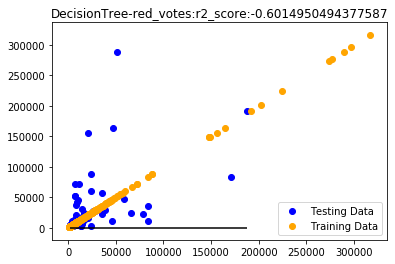

donation_votes_linear_regression
y len 384 x len 384
Running a Linear Regression Model with y=other_votes and x_cols=['PopPct_Urban', 'Unemployment', 'PopDen_Urban', 'PopPct_Rural', 'PopDen_Rural', 'county', 'election_year', 'blue_amt', 'red_amt', 'total_amt', 'blue_num', 'red_num'] state=MI


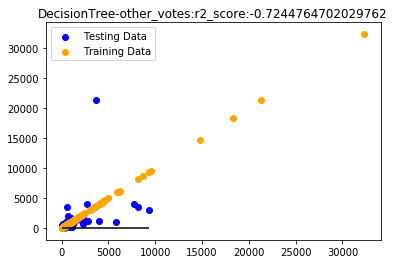

county
state
winning_party
len of y_test_blue 83 y_test_red83 y_test_other_pred83
Prediction for Votes! States = MI
agg_ml FL
county
state
county
state
winning_party
donation_votes_linear_regression
y len 309 x len 309
Running a Linear Regression Model with y=blue_votes and x_cols=['PopPct_Urban', 'Unemployment', 'PopDen_Urban', 'PopPct_Rural', 'PopDen_Rural', 'county', 'election_year', 'blue_amt', 'red_amt', 'total_amt', 'blue_num', 'red_num'] state=FL


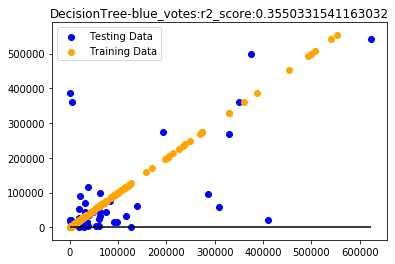

donation_votes_linear_regression
y len 309 x len 309
Running a Linear Regression Model with y=red_votes and x_cols=['PopPct_Urban', 'Unemployment', 'PopDen_Urban', 'PopPct_Rural', 'PopDen_Rural', 'county', 'election_year', 'blue_amt', 'red_amt', 'total_amt', 'blue_num', 'red_num'] state=FL


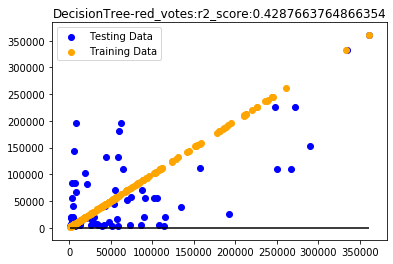

donation_votes_linear_regression
y len 309 x len 309
Running a Linear Regression Model with y=other_votes and x_cols=['PopPct_Urban', 'Unemployment', 'PopDen_Urban', 'PopPct_Rural', 'PopDen_Rural', 'county', 'election_year', 'blue_amt', 'red_amt', 'total_amt', 'blue_num', 'red_num'] state=FL


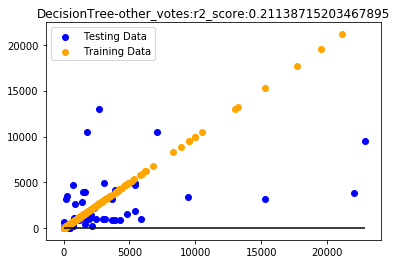

county
state
winning_party
len of y_test_blue 67 y_test_red67 y_test_other_pred67
Prediction for Votes! States = FL
agg_ml NC
county
state
county
state
winning_party
donation_votes_linear_regression
y len 362 x len 362
Running a Linear Regression Model with y=blue_votes and x_cols=['PopPct_Urban', 'Unemployment', 'PopDen_Urban', 'PopPct_Rural', 'PopDen_Rural', 'county', 'election_year', 'blue_amt', 'red_amt', 'total_amt', 'blue_num', 'red_num'] state=NC


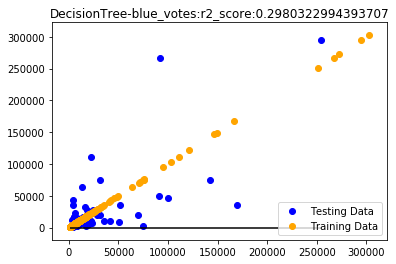

donation_votes_linear_regression
y len 362 x len 362
Running a Linear Regression Model with y=red_votes and x_cols=['PopPct_Urban', 'Unemployment', 'PopDen_Urban', 'PopPct_Rural', 'PopDen_Rural', 'county', 'election_year', 'blue_amt', 'red_amt', 'total_amt', 'blue_num', 'red_num'] state=NC


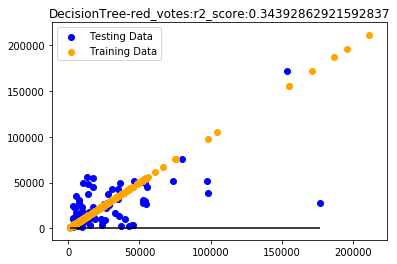

donation_votes_linear_regression
y len 362 x len 362
Running a Linear Regression Model with y=other_votes and x_cols=['PopPct_Urban', 'Unemployment', 'PopDen_Urban', 'PopPct_Rural', 'PopDen_Rural', 'county', 'election_year', 'blue_amt', 'red_amt', 'total_amt', 'blue_num', 'red_num'] state=NC


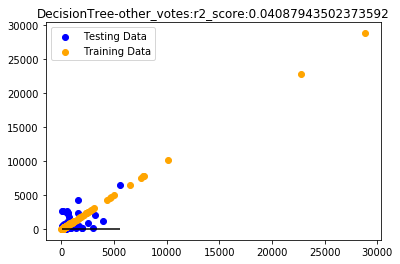

county
state
winning_party
len of y_test_blue 100 y_test_red100 y_test_other_pred100
Prediction for Votes! States = NC
agg_ml PA
county
state
county
state
winning_party
donation_votes_linear_regression
y len 323 x len 323
Running a Linear Regression Model with y=blue_votes and x_cols=['PopPct_Urban', 'Unemployment', 'PopDen_Urban', 'PopPct_Rural', 'PopDen_Rural', 'county', 'election_year', 'blue_amt', 'red_amt', 'total_amt', 'blue_num', 'red_num'] state=PA


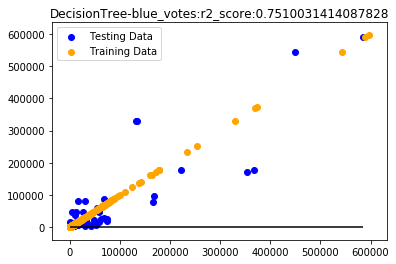

donation_votes_linear_regression
y len 323 x len 323
Running a Linear Regression Model with y=red_votes and x_cols=['PopPct_Urban', 'Unemployment', 'PopDen_Urban', 'PopPct_Rural', 'PopDen_Rural', 'county', 'election_year', 'blue_amt', 'red_amt', 'total_amt', 'blue_num', 'red_num'] state=PA


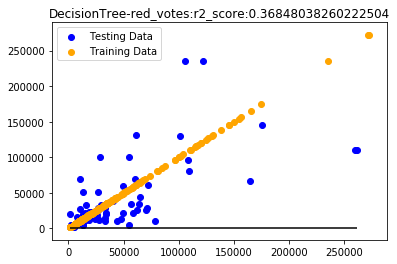

donation_votes_linear_regression
y len 323 x len 323
Running a Linear Regression Model with y=other_votes and x_cols=['PopPct_Urban', 'Unemployment', 'PopDen_Urban', 'PopPct_Rural', 'PopDen_Rural', 'county', 'election_year', 'blue_amt', 'red_amt', 'total_amt', 'blue_num', 'red_num'] state=PA


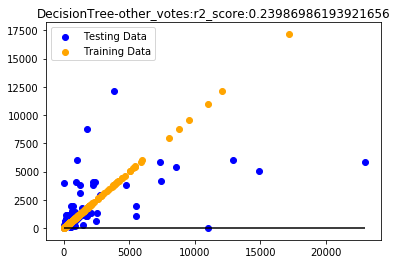

county
state
winning_party
len of y_test_blue 67 y_test_red67 y_test_other_pred67
Prediction for Votes! States = PA
agg_ml WI
county
state
county
state
winning_party
donation_votes_linear_regression
y len 346 x len 346
Running a Linear Regression Model with y=blue_votes and x_cols=['PopPct_Urban', 'Unemployment', 'PopDen_Urban', 'PopPct_Rural', 'PopDen_Rural', 'county', 'election_year', 'blue_amt', 'red_amt', 'total_amt', 'blue_num', 'red_num'] state=WI


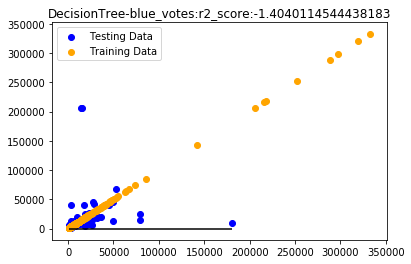

donation_votes_linear_regression
y len 346 x len 346
Running a Linear Regression Model with y=red_votes and x_cols=['PopPct_Urban', 'Unemployment', 'PopDen_Urban', 'PopPct_Rural', 'PopDen_Rural', 'county', 'election_year', 'blue_amt', 'red_amt', 'total_amt', 'blue_num', 'red_num'] state=WI


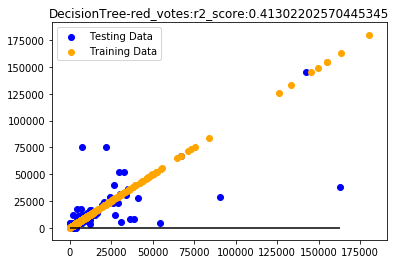

donation_votes_linear_regression
y len 346 x len 346
Running a Linear Regression Model with y=other_votes and x_cols=['PopPct_Urban', 'Unemployment', 'PopDen_Urban', 'PopPct_Rural', 'PopDen_Rural', 'county', 'election_year', 'blue_amt', 'red_amt', 'total_amt', 'blue_num', 'red_num'] state=WI


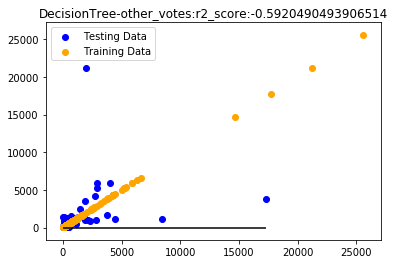

county
state
winning_party
len of y_test_blue 72 y_test_red72 y_test_other_pred72
Prediction for Votes! States = WI
End of Main


<Figure size 432x288 with 0 Axes>

In [18]:
print("Main")
committee_df = pd.read_sql_query('select "CMTE_ID","CMTE_PTY_AFFILIATION" from "committees"', con=engine)
#Drop the tables that will be outputed to the results res_lr
#drop_res_lr_tables(engine)

for state in SWING_STATES:
    agg_ml(state)
    #state_ml(committee_df, state)

print("End of Main")